In [1]:
import numpy as np
import scipy
from scipy import misc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# figsize(15,6)
# V = linspace(-3,3,1000)
# I = (V**3)/10 *exp(0.025*sin(10*2*pi*V)) 
# fit = poly1d(polyfit(V,I,3))
# plot(V,I)
# # plot(V,fit(V))
# print(a[0])
# tick_params(labelsize=12,colors='white')
# xlabel('Voltage',size=20,color='white')
# ylabel('Current',size=20,color='white')
# # xlim(-3,-2.8)

0.1 0.2 11
(11,)
(22000,)


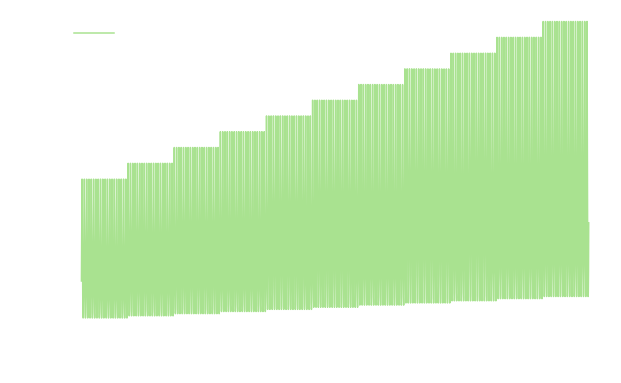

In [16]:
figsize(10,6)
V_step = 10e-3 #0.5 mV - 50 mV
steps = 10
t_step = 0.2 #time per voltage step
fs = 10000
start = 0.1
end = start+steps*V_step

print(start,end,int(around((end-start)/V_step+1)))
VMap = linspace(start,end,int(around((end-start)/V_step)+1))
print(shape(VMap))
t = linspace(0,t_step*len(VMap),int(t_step*len(VMap)*fs))
VMap = repeat(VMap,int(t_step*fs))
print(shape(VMap))
dV = 2e-3*sin(1200*2*pi*t)
V = VMap+dV
G = sin(100*2*pi*t+0.25*pi)
Z = 1e-10*sin(100*2*pi*t)
kappa = -1e10
R = 1/V**2
I = (V)*exp(-kappa*Z)
# print(V[::2000]/R[::2000])
# print(len(t),len(V))
fig,ax = subplots(1,1)
plot(t,I,'#a9e290',label='Voltage modulation')
tick_params(labelsize=12,colors='white')
xlabel('Time (secs)',size=20,color='white')
ylabel('Voltage (mV)',size=20,color='white')
leg= legend(loc=0,fontsize = 20,fancybox=True, framealpha=0)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
# xlim(0,1)
# ylim(-0.5,0.5)
savefig('volt',transparent=True)

[ 2000  4000  6000  8000 10000 12000 14000 16000 18000 20000    -1]


Text(0, 0.5, 'Amplitude')

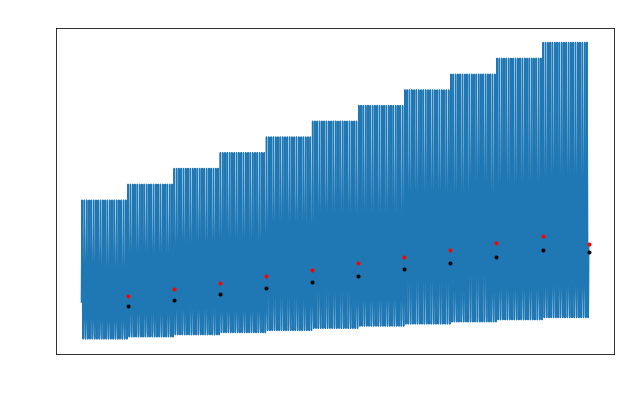

In [17]:
#----------------Breakpoint calculation---------------------------
from scipy import signal
def low_pass(sig,fs,cutoff=1000):
    b, a = signal.butter(8, cutoff/fs,btype='lowpass')
    filtered = signal.filtfilt(b, a, sig, padlen=200)
    return filtered
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

filt_sig = low_pass(V,10000)
dt = t[1]
grad = np.gradient(filt_sig,dt)
brk_pnt = np.flip(np.argsort(grad))[:steps*2]
brk_pnt = -np.sort(-brk_pnt)
# print(brk_pnt)
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    brk_pnt[idx] = point
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
brk_pnt = np.append(brk_pnt,-1)
print(brk_pnt)
#-----------------------------------------------------------------------------
plot(t,I,label="Current")
# plot(t, filt_sig)
# plot(t,1e-3*grad+1)
plot(t[brk_pnt],I[brk_pnt],'r.')
plot(t[brk_pnt-1],I[brk_pnt-1],'k.')

# xlim(0.79,0.81)
tick_params(labelsize=12,colors='white')
title('Gradient map',size=20,color='white')
xlabel('Time (secs)',size=20,color='white')
ylabel('Amplitude',size=20,color='white')

In [18]:
#------------I_0 calculations------------------
prev = 0 

# print((brk_pnt))
I_0 = np.zeros(steps+1)
for idx,point in enumerate(brk_pnt):
    I_0[idx] = mean(I[prev:point]) 
    prev = point
print(I_0)
I_0 = repeat(I_0,int(len(I)/(steps+1)))
print(len(I),len(I_0),I_0[0])
#----------------------------

[0.12660522 0.13926578 0.15192634 0.16458691 0.17724749 0.18990807
 0.20256865 0.21522924 0.22788984 0.24055044 0.25323767]
22000 22000 0.12660521894212315


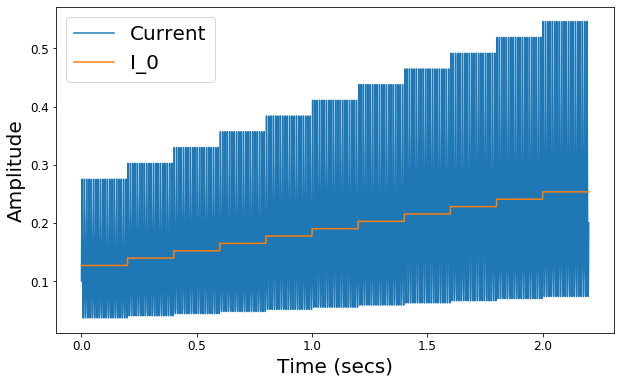

In [19]:
#----------------I_noise estimation-----------
figsize(10,6)
from scipy import signal
t_test = linspace(0,25,250000)
G_cal = sin(100*2*pi*t_test + 0.25*pi)
Z_cal = 1e-10*sin(100*2*pi*t_test)
kappa = -1e9
V_i = 1 #+ 2e-3*sin(1200*2*pi*t_test)
R_i = 1/V_i**2
I_cal = (V_i/R_i)*exp(-kappa*Z_cal)
freqs = np.fft.fftfreq(len(G_cal),1/10000)
T_exact = np.fft.fft(Z_cal)/np.fft.fft(G_cal)
T_new = np.fft.fft(I_cal)/(np.fft.fft(G_cal))
T_exact = scipy.interpolate.interp1d(freqs, T_exact, kind='linear',fill_value='extrapolate')
T_new = scipy.interpolate.interp1d(freqs, T_new, kind='linear',fill_value='extrapolate')
freqs_I = np.fft.fftfreq(len(G),1/10000)
Z_noise = np.fft.ifft(T_exact(freqs_I)*np.fft.fft(G))
I_noise = np.fft.ifft(T_new(freqs_I)*np.fft.fft(G))
I_sig_1 = I/exp(-kappa*Z_noise)
I_sig_2 = I_0
I_sig_3 = I_noise
plot(t,I,label='Current')
plot(t,I_sig_2,label='I_0')
# plot(t,I_sig_2,label='Calculation from I_0')
# plot(t,I_sig_3)
# plot(t,V/R)
legend(fontsize=20)
tick_params(labelsize=12,colors='k')
# title('I cancellation',size=20,color='white')
xlabel('Time (secs)',size=20,color='k')
ylabel('Amplitude',size=20,color='k')
savefig('Direct Propogation')
# xlim(0.29,0.31)
#---------------------------------------------

In [20]:
# folder_loc = 'LIY/'
# file_loc = 'liy_3-260.dat'
# print(folder_loc+file_loc)
# dat = np.loadtxt(folder_loc+file_loc,skiprows=6)
# # Z_rel = dat[:,0]
# # Current = dat[:,1]
# # Z = dat[:,2]
# # Current_bwd = dat[:,3]
# # Z_bwd = dat[:,4]
# for filename in os.listdir(folder_loc):
#     if filename == file_loc:
#         pass
#     try:
#         tempdata = np.loadtxt(folder_loc+filename, skiprows=6)
#         dat = np.concatenate((dat,tempdata))
#         print(filename,end='\r')
#     except:
#         print('ERROR: ',filename)

In [21]:
# plot(Z_rel)
# plot(Z)
# plot(Z_bwd)
# plot(Current)
# plot(Current_bwd)

[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]


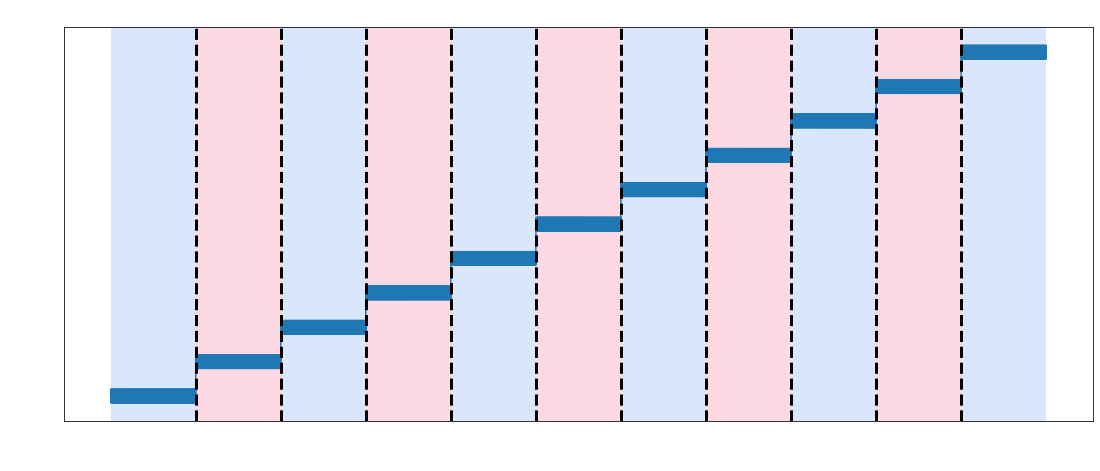

In [22]:
import matplotlib.pyplot as plt
import ruptures as rpt

fitted = rpt.Binseg(model="l2",jump=100).fit(V)
prediction = fitted.predict(n_bkps=steps)
print(prediction)
rpt.show.display(V,prediction,prediction, figsize=(15, 6))

plt.tick_params(labelsize=12,colors='white')
plt.title('Breakpoint map',size=20,color='white')
plt.xlabel('Time (secs)',size=20,color='white')
plt.ylabel('Amplitude',size=20,color='white')
# xlim(0,2100)
plt.show()
# plt.xlim(0,1000)

(990000,) (990000,)


(0, 1)

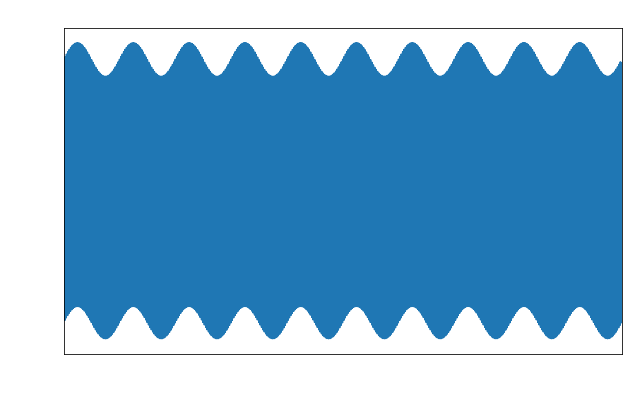

In [28]:

t= linspace(0,99,990000)
G = sin(10*2*pi*t)
Z = 0.00000025*sin(10*2*pi*t)
V_i = 1
dV = 0.02*sin(1200*2*pi*t)
print(shape(t),shape(dV))
R = 200e6
k = 10000
I_i = ((V_i + dV)/R)*exp(k*Z)
plot(t,I_i)
tick_params(labelsize=12,colors='white')
title("Current at a single voltage",size=20,color='white')
xlabel('Time (secs)',size=20,color='white')
ylabel('Current',size=20,color='white')
xlim(0,1)

(990000,) (990000,)


(0.07304343617547562, 0.2269565638244484)

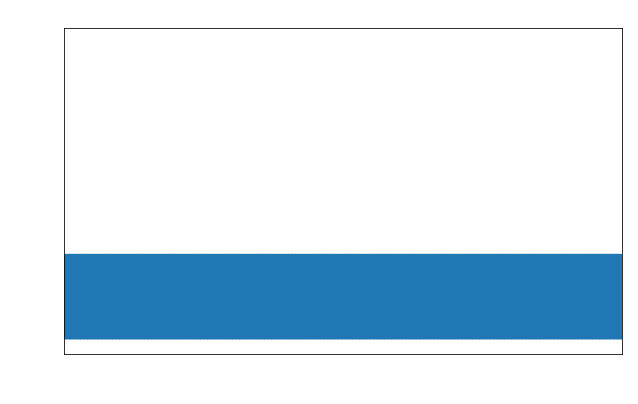

In [29]:

VMap = repeat(VMap,int(len(t)/len(VMap)))
print(shape(VMap),shape(dV))
R = 1/VMap**2
V = VMap + dV
I = (V)
plot(t,I)
tick_params(labelsize=12,colors='white')
title('Voltage steps',size=20,color='white')
xlabel('Time (secs)',size=20,color='white')
ylabel('Voltage',size=20,color='white')
xlim(0,1)
ylim()

Text(0, 0.5, 'Amplitude')

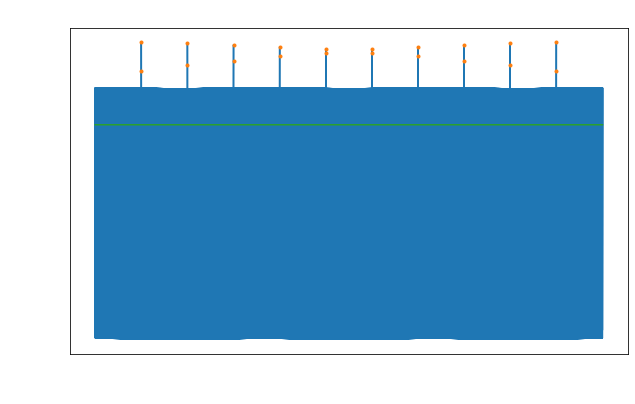

In [30]:
dt = t[1]
grad = np.gradient(V,dt)
loc = np.where(grad>140)
one = (sqrt(mean(grad**2)))*np.ones(len(grad))
plot(t,grad)
plot(t[loc],grad[loc],'.')
plot(t,one)
tick_params(labelsize=12,colors='white')
title('Gradient map',size=20,color='white')
xlabel('Time (secs)',size=20,color='white')
ylabel('Amplitude',size=20,color='white')
# xlim(0,0.1)
# ylim(0,300)

Text(0, 0.5, 'Current')

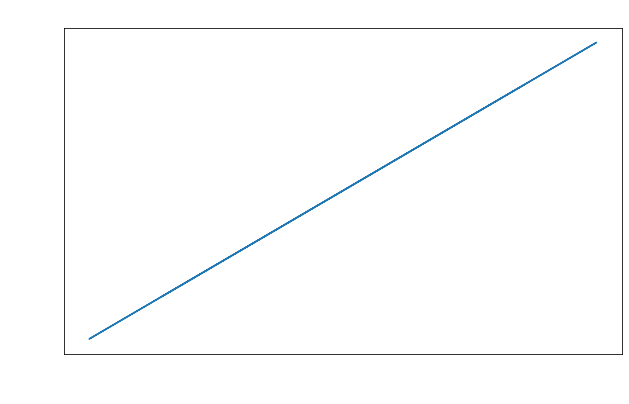

In [31]:
plot(VMap+dV,I)
# plot(VMap+dV,R)
tick_params(labelsize=12,colors='white')
title('Current with voltage steps',size=20,color='white')
xlabel('Voltage',size=20,color='white')
ylabel('Current',size=20,color='white')
# xlim(-3,-2.9)

In [32]:
G_ft = fft.fft(G)
Z_ft = fft.fft(Z)
T = Z_ft/G_ft


In [33]:
step = 0.5e-4
x = linspace(0,1,int(1/step))
print(x[1])

5.000250012500625e-05


In [34]:
x = linspace(0,9,10)
print((x))
print((-np.sort(-x)))


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[9. 8. 7. 6. 5. 4. 3. 2. 1. 0.]


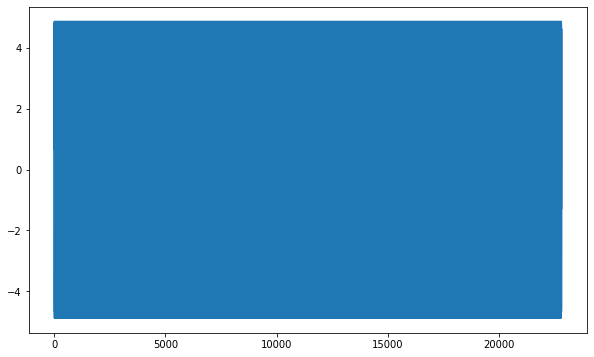

In [35]:
folder_loc = 'LIY/'
file_loc = 'liy_3-269.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=6)
plot(dat[:,1])
# xlim(0,1000)
# for filename in os.listdir(folder_loc):
#     if filename == file_loc:
#         pass
#     try:
#         tempdata = np.loadtxt(folder_loc+filename, skiprows=94)
#         dat = np.concatenate((dat,tempdata))
#         print(filename,end='\r')
#     except:
#         print('ERROR: ',filename)

Text(0.5, 1.0, 'Time Trace')

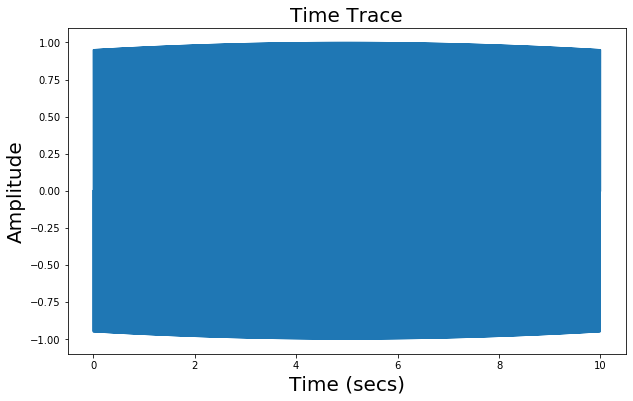

In [36]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import wavfile

sampling_rate = 1000
t = linspace(0,10,10*sampling_rate) # time array = 10 seconds at 1000 samples per second
theta = 0.5*pi #phase
x = sin(100*2*pi*t + pi) #time trace of x
plot(t,x)
xlabel('Time (secs)',size=20)
ylabel('Amplitude',size = 20)
title('Time Trace', size = 20)

(-0.0030679203063828098+0.0976228070740382j)


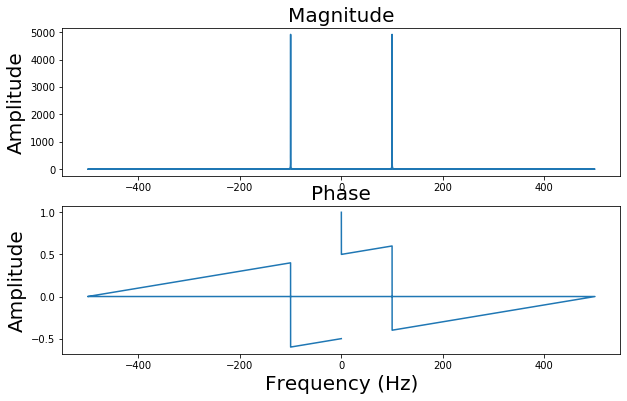

In [37]:
fft_x  = np.fft.fft(x) # Gives a complex number: Amplitude and Phase 
freqs = np.fft.fftfreq(len(x),1/sampling_rate) # Gives frequency signature of signal (same shape as x)
# longer signal gives more resolution: 1 sec data - 1 Hz resolution, 10 secs - 0.1 Hz, 100 secs - 0.01 Hz
# Sampling rate gives max calculable frequency as sampling-rate/2: 1000 Hz sampling rate - 500 Hz max fft frequency
fig, ax = subplots(2,1)

ax[0].plot(freqs,absolute(fft_x))
ax[0].set_title("Magnitude",size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(freqs,angle(fft_x)/pi)
ax[1].set_title("Phase",size=20)
ax[1].set_xlabel("Frequency (Hz)",size=20)
ax[1].set_ylabel("Amplitude", size=20)
print(fft_x[100])

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Amplitude')

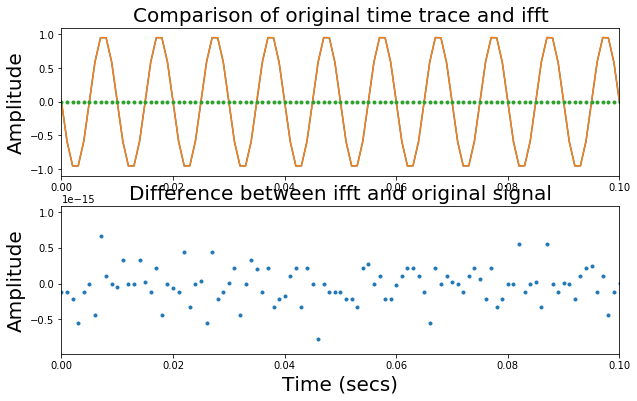

In [38]:
ifft_x = np.fft.ifft(fft_x) #Brings data from frequency domain to time domain
#the length of fft_x should equal the length of x
#fft_x should be a complex conjugate (not a problem if you just use built in functions)

fig,ax = subplots(2,1)
ax[0].plot(t,ifft_x)
ax[0].plot(t,x)
ax[0].plot(t,ifft_x-x,'.')
ax[0].set_xlim(0,0.1)
ax[0].set_title('Comparison of original time trace and ifft',size=20)
ax[0].set_ylabel('Amplitude',size=20)

#Notice the inverse fft of the unchanged signal is very very close to the original signal 
ax[1].plot(t,ifft_x-x,'.')
ax[1].set_xlim(0,0.1)
ax[1].set_title('Difference between ifft and original signal',size=20)
ax[1].set_xlabel('Time (secs)',size=20)
ax[1].set_ylabel('Amplitude',size=20)

Text(0, 0.5, 'Frequency (Hz)')

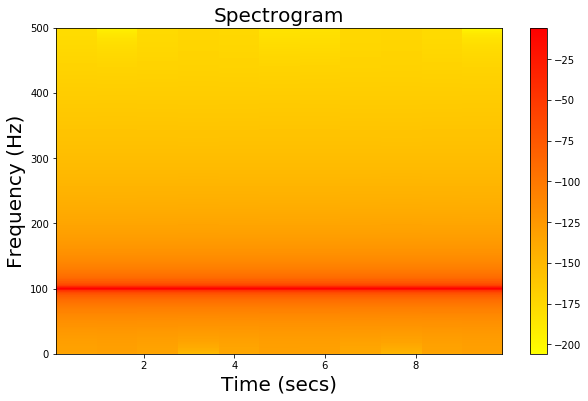

In [39]:
#Spectrogram plots frequency and time on the same plot chopping the time signal into many pieces and 
#  calculating the fft of each one
#There is a tradeoff with this for time resolution and frequency ersolution
spectrum, freqs, t_spec, im = plt.specgram(x, Fs=sampling_rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar = plt.colorbar(im)
title("Spectrogram",size=20)
xlabel("Time (secs)",size=20)
ylabel("Frequency (Hz)",size=20)

(0, 0.5)

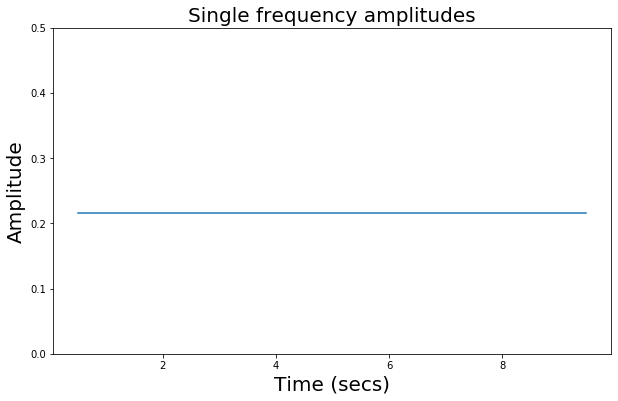

In [40]:
#Find the amplitude information of a specific frequency
#  can be used to calculate reverberation time of an actual sound file
# print(freqs)
index_of_frequency = np.where(freqs == 100.5859375)[0][0]
data_for_frequency = spectrum[index_of_frequency]
plot(t_spec,data_for_frequency)
title("Single frequency amplitudes", size=(20))
xlabel("Time (secs)",size=20)
ylabel("Amplitude",size=20)
ylim(0,0.5)